In [37]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
#import unicodedata
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
import gensim
from sklearn.model_selection import train_test_split
nlp = spacy.load("en_core_web_sm")
import time
import json
import string

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
stopword_list.remove('up')
stopword_list.remove('down')

In [13]:
df = pd.read_csv('./data/all-data.csv', names = ['labels','messages'],encoding='ISO-8859-1')

In [14]:
df.head()

,labels,messages
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


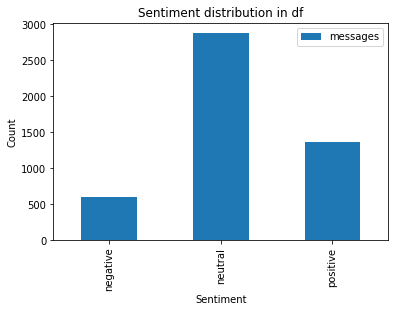

In [15]:
df.groupby(['labels']).count().plot.bar()
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.title("Sentiment distribution in df")
plt.show()

In [16]:
### remove stopwords

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

In [17]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

In [19]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("Returning books is something I remain thinking about") #odd sentence, I know

'return book be something I remain think about'

In [20]:
def normalize_text(text):
    exp = expand_contractions(text)
    low = exp.lower()
    lemm = lemmatize_text(low)
    no_sw = remove_stopwords(lemm)
    return simple_preprocess(no_sw)

In [21]:
#### text preprocess:

df['messages'] = [normalize_text(row) for row in df['messages']]

In [22]:
df.iloc[0]['messages'][:3]

['accord', 'gran', 'company']

In [23]:
### map sentiment to int:

def map_sentiment(sentiment):
    if sentiment == 'negative':
        return 0
    elif sentiment == 'neutral':
        return 2
    else:
        return 4

In [24]:
df['labels'] = [map_sentiment(row) for row in df['labels']]

In [25]:
df['labels'].head(3)

0    2
1    2
2    0
Name: labels, dtype: int64

Number of rows per sentiment:
2    2879
4    1363
0     604
Name: labels, dtype: int64


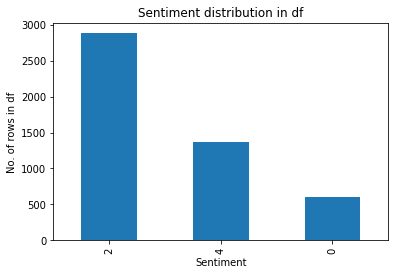

In [26]:
print("Number of rows per sentiment:")
print(df['labels'].value_counts())

plt.figure()
pd.value_counts(df['labels']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [27]:
df.to_csv('preprocessed-text.csv', sep = ',')

In [28]:
# Train-Test Split Function
def split_train_test(df, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df['messages'], 
                                                        df['labels'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df)

Value counts for Train sentiments
2    2000
4     956
0     436
Name: labels, dtype: int64
Value counts for Test sentiments
2    879
4    407
0    168
Name: labels, dtype: int64
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
   index                                           messages
0   2988  [market, share, percent, accord, ac, nielsen, ...
1   3236                   [ecb, mainly, target, inflation]
2   2061  [scania, morgan, stanley, lift, share, target,...
3   3002  [kirsi, rantanen, previously, development, dir...
4   1417  [russian, government, contribute, necessary, f...


In [34]:
X_train.drop("index", axis=1, inplace=True)
X_test.drop("index", axis=1, inplace=True)
Y_train.drop("index", axis=1, inplace=True)
Y_test.drop("index", axis=1, inplace=True)

In [29]:
### above is fine
### below needs to be redone

In [53]:
X_train = pd.Series(X_train['messages'].values)

code below from: https://stackoverflow.com/questions/52038651/loss-does-not-decrease-during-training-word2vec-gensim/52067942

In [30]:
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec

# init callback class
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss() 
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [56]:
# init word2vec class
w2v_model = Word2Vec(vector_size=300, # 300 dimension vector
                     window=15, # how many neighbors around a particular word
                     min_count=2, # the word needs to appear at least two times in the corpus
                     workers=20, # speed of training
                     sg=1, # sg=1 means this is a skip-gram model
                     negative=5, # num of negative samples
                     sample=1e-5) # sampling rate


# build vovab
w2v_model.build_vocab(X_train)
  
# train the w2v model
start = time.time()
w2v_model.train(X_train, 
                total_examples=w2v_model.corpus_count, #num of training samples
                epochs=5, 
                report_delay=1,
                compute_loss = True, # set compute_loss = True
                callbacks=[callback()]) # add the callback class
end = time.time()

print("elapsed time in seconds: " + str(end-start))
# save the word2vec model
w2v_model.save('fin_word2vec5.model')

Loss after epoch 0: 14214.0126953125
Loss after epoch 1: 14787.6044921875
Loss after epoch 2: 14425.35546875
Loss after epoch 3: 16357.63671875
Loss after epoch 4: 15504.9296875
elapsed time in seconds: 0.08844995498657227


In [64]:
fin_w2v_model = Word2Vec.load('fin_word2vec20.model')
words = list(fin_w2v_model.wv.index_to_key)
print('Word2Vec Model Exploration:')
print("Vocab size: " +str(len(words)))

w1= 'buy'
print("Top 3 words similar to buy:",\
     fin_w2v_model.wv.most_similar(positive= w1, topn=3))

w2= 'sell'
print("Top 3 words similar to sell:",\
     fin_w2v_model.wv.most_similar(positive= w2, topn=3))

print("Similarity between 'buy' and 'profit'",\
     str(fin_w2v_model.wv.similarity("buy", "profit")))

print("Similarity between 'sell' and 'loss'",\
     str(fin_w2v_model.wv.similarity("sell", "loss")))

print("Vector distance of 'buy' and 'sell'",\
     str(fin_w2v_model.wv.distance("buy", "sell")))

print("Vector distance of 'profit' and 'loss'",\
     str(fin_w2v_model.wv.distance("profit", "loss")))

print("Vector representation of 'asset':",\
      fin_w2v_model.wv.get_vector("asset"))

Word2Vec Model Exploration:
Vocab size: 3056
Top 3 words similar to buy: [('company', 0.9848516583442688), ('service', 0.9838883876800537), ('finnish', 0.983462393283844)]
Top 3 words similar to sell: [('company', 0.9864970445632935), ('service', 0.9851124286651611), ('say', 0.9847131371498108)]
Similarity between 'buy' and 'profit' 0.95790493
Similarity between 'sell' and 'loss' 0.9577688
Vector distance of 'buy' and 'sell' 0.02530360221862793
Vector distance of 'profit' and 'loss' 0.05438357591629028
Vector representation of 'asset': [-2.48648808e-04  6.76754070e-03  6.13760296e-03  1.20333480e-02
 -8.09674338e-03 -1.09480759e-02  2.38281721e-03  2.35084426e-02
  1.67235117e-02 -1.03755835e-02 -1.28494930e-02 -9.88984853e-03
  1.30320871e-02 -2.69775442e-03 -1.59106497e-02 -1.67744774e-02
  1.88445044e-03 -2.14561750e-03  1.34274876e-02  5.06266812e-03
 -6.21647853e-03  1.19132797e-04  9.54275671e-03  6.12904970e-03
  2.42953002e-02  9.74640774e-04 -4.20973497e-03  1.54747559e-05
 -8

**Results:**

Perhaps most notably is the size of the vocabulary. 3056 is not a large word count; chances are the results would be overfit to this specific set of sentences. As always, to have a truly predictive model, far more data would be required. 

To access a pretrained Word2Vec model, Google's can be accessed in the following manner:

```python

import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)
```

In [26]:
# Store the vectors for train data in following file
word2vec_filename = './data' + 'train_review_word2vec.csv'
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in X_train.iterrows():
        model_vector = (np.mean([i for i in sg_w2v_model.wv.vectors], axis=0)).tolist()
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(1000)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

In [27]:
train_data = pd.read_csv('datatrain_review_word2vec.csv')

In [28]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.052688,0.033104,0.004593,-0.010094,-0.004568,-0.121286,0.044553,0.114717,-0.053044,-0.053647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.052688,0.033104,0.004593,-0.010094,-0.004568,-0.121286,0.044553,0.114717,-0.053044,-0.053647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.052688,0.033104,0.004593,-0.010094,-0.004568,-0.121286,0.044553,0.114717,-0.053044,-0.053647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.052688,0.033104,0.004593,-0.010094,-0.004568,-0.121286,0.044553,0.114717,-0.053044,-0.053647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.052688,0.033104,0.004593,-0.010094,-0.004568,-0.121286,0.044553,0.114717,-0.053044,-0.053647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Store the vectors for test data in following file
word2vec_filename = './data' + 'test_review_word2vec.csv'
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in X_test.iterrows():
        model_vector = (np.mean([i for i in sg_w2v_model.wv.vectors], axis=0)).tolist()
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(1000)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

In [32]:
Y_train.to_csv('y_train.csv')

In [33]:
Y_test.to_csv('y_test.csv')

In [37]:
X_train

,index,messages
0,2988,"[market, share, percent, accord, ac, nielsen, ..."
1,3236,"[ecb, mainly, target, inflation]"
2,2061,"[scania, morgan, stanley, lift, share, target,..."
3,3002,"[kirsi, rantanen, previously, development, dir..."
4,1417,"[russian, government, contribute, necessary, f..."
...,...,...
3387,3271,"[insolvency, act, regulate, amount, debt, borr..."
3388,2715,"[nordic, infrastructure, construction, one, st..."
3389,2204,"[company, also, expect, sell, product, russian..."
3390,2693,"[solution, extension, exist, online, mediation..."


In [60]:
import time
#Import the DecisionTreeeClassifier
from sklearn.tree import DecisionTreeClassifier

#Initialize the model
clf_decision_word2vec = DecisionTreeClassifier()

start_time = time.time()
# Fit the model
clf_decision_word2vec.fit(X_train, Y_train.labels.values)
print("Time taken to fit the model with word2vec vectors: " + str(time.time() - start_time))


Time taken to fit the model with word2vec vectors: 0.01562976837158203


In [61]:
from sklearn.metrics import classification_report
X_test = pd.read_csv('datatest_review_word2vec.csv')
X_test.dropna(axis=1, how='all', inplace=True)

y_pred = clf_decision_word2vec.predict(X_test)
print(classification_report(Y_test.labels.values,y_pred, zero_division=0))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       168
           0       0.60      1.00      0.75       879
           1       0.00      0.00      0.00       407

    accuracy                           0.60      1454
   macro avg       0.20      0.33      0.25      1454
weighted avg       0.37      0.60      0.46      1454



In [62]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test.labels.values,y_pred)

array([[  0, 168,   0],
       [  0, 879,   0],
       [  0, 407,   0]])

Provisional results:

There are likely one of three reasons that the model is exclusively predicting neutral:

1. Imbalance: the data is too imbalanced, thus the model fit is skewed towards a neutral prediction
2. Insufficient data: The data the model trained on is simply not robust enough to have predictive merit
3. Unique language: The technical language in financial headlines is uniquely difficult to perform SA on, compared to "this cheeseburger is delicious".
4. Bad choice of model. Something more robust than a decision tree is needed.